# Lab 3 - Part 2: Word and Sentence Embeddings

**Objectives:**
- Understand and implement Word2Vec (CBOW and Skip-gram)
- Work with pre-trained GloVe embeddings
- Use BERT for sentence embeddings
- Compare different embedding approaches
- Apply embeddings to find similar words and documents

---

## Instructions

1. Complete all exercises marked with `# YOUR CODE HERE`
2. **Answer all written questions** in the designated markdown cells
3. Save your completed notebook
4. **Push to your Git repository and send the link to: yoroba93@gmail.com**

### Important: This lab continues from Part 1

You will use the same dataset and categories you chose in Part 1.

---

## Setup

In [ ]:
# Install required libraries (uncomment if needed)
# !pip install gensim transformers torch sentence-transformers datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import string
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

print(f"Gensim version: {gensim.__version__}")
print("Setup complete!")

Gensim version: 4.3.3
Setup complete!


## Load Dataset (Same as Part 1)

In [11]:
import pandas as pd

url = "https://huggingface.co/datasets/SetFit/20_newsgroups/resolve/main/train.jsonl"
df = pd.read_json(url, lines=True)

# TODO: Use the SAME 3 categories you chose in Part 1!
my_categories =   [  "comp.graphics",  #Helps improve model learning, make words clouds more interpretable
    "sci.space",
    "alt.atheism"
]

# Filter dataset
df_filtered = df[df['label_text'].isin(my_categories)].copy()
df_filtered = df_filtered.reset_index(drop=True)

print(f"Selected categories: {my_categories}")
print(f"Filtered dataset size: {len(df_filtered)}")

Selected categories: ['comp.graphics', 'sci.space', 'alt.atheism']
Filtered dataset size: 1657


In [15]:
# Preprocessing function (same as Part 1)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess text for embedding training."""
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)                 # remove emails
    text = re.sub(r'http\S+|www\S+', '', text)          # remove URLs
    text = re.sub(r'\d+', '', text)                     # remove numbers
    text = re.sub(rf"[{string.punctuation}]", ' ', text) # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()            # normalize whitespace
 # YOUR CODE HERE  => the same as in Part 1 (advanced preprocessing)
    tokens = word_tokenize(text)

    # Step 3: Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Step 4: Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Step 5: Remove short words (< 3 chars)
    tokens = [word for word in tokens if len(word) >= 3]    # YOUR CODE HERE  => the same as in Part 1 (advanced preprocessing)
    return tokens  # Return list of tokens for Word2Vec

# Apply preprocessing
df_filtered['tokens'] = df_filtered['text'].apply(preprocess_text)
df_filtered['text_clean'] = df_filtered['tokens'].apply(' '.join)

print(f"Sample tokens: {df_filtered.iloc[0]['tokens'][:20]}")

Sample tokens: ['weitek', 'address', 'phone', 'number', 'like', 'get', 'information', 'chip']


---

## Part A: Word2Vec - Training Your Own Embeddings

Word2Vec learns word representations by predicting context. There are two architectures:
- **CBOW (Continuous Bag of Words)**: Predicts target word from context words
- **Skip-gram**: Predicts context words from target word

### A.1 Understanding Word2Vec Architectures

In [18]:
# Prepare corpus for Word2Vec (list of tokenized sentences)
corpus = df_filtered['tokens'].tolist()

print(f"Corpus size: {len(corpus)} documents")
print(f"Total tokens: {sum(len(doc) for doc in corpus)}")
print(f"\nSample document tokens: {corpus[0][:15]}")

Corpus size: 1657 documents
Total tokens: 160692

Sample document tokens: ['weitek', 'address', 'phone', 'number', 'like', 'get', 'information', 'chip']


In [20]:
# Train Word2Vec with CBOW (sg=0)
model_cbow = Word2Vec(
    sentences=corpus,
    vector_size=100,      # Embedding dimension
    window=5,             # Context window size
    min_count=5,          # Ignore words with freq < 5
    workers=4,            # Parallel threads
    sg=0,                 # 0 = CBOW, 1 = Skip-gram
    epochs=10             # Training epochs
)

print(f"CBOW Model trained!")
print(f"Vocabulary size: {len(model_cbow.wv)}")

CBOW Model trained!
Vocabulary size: 4827


In [22]:
# Train Word2Vec with Skip-gram (sg=1)
model_skipgram = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,                 # Skip-gram
    epochs=10
)

print(f"Skip-gram Model trained!")
print(f"Vocabulary size: {len(model_skipgram.wv)}")

Skip-gram Model trained!
Vocabulary size: 4827


### A.2 Exploring Word Embeddings

In [24]:
# Example: Get word vector
sample_word = "computer"  # Change this to a word relevant to YOUR categories

if sample_word in model_cbow.wv:
    vector = model_cbow.wv[sample_word]
    print(f"Vector for '{sample_word}':")
    print(f"  Shape: {vector.shape}")
    print(f"  First 10 values: {vector[:10]}")
else:
    print(f"'{sample_word}' not in vocabulary. Try another word.")
    print(f"Sample words in vocab: {list(model_cbow.wv.key_to_index.keys())[:20]}")

Vector for 'computer':
  Shape: (100,)
  First 10 values: [-0.50422466 -0.23671894  0.7429204  -0.02138725 -0.07758842 -0.7296408
  0.5259032   0.85598266 -0.49744427 -0.25299847]


In [26]:
# Find similar words
sample_word = "computer"  # Change to a word in YOUR vocabulary

if sample_word in model_cbow.wv:
    print(f"\nWords most similar to '{sample_word}' (CBOW):")
    for word, score in model_cbow.wv.most_similar(sample_word, topn=10):
        print(f"  {word}: {score:.4f}")
    
    print(f"\nWords most similar to '{sample_word}' (Skip-gram):")
    for word, score in model_skipgram.wv.most_similar(sample_word, topn=10):
        print(f"  {word}: {score:.4f}")


Words most similar to 'computer' (CBOW):
  application: 0.9655
  user: 0.9568
  visualization: 0.9536
  ibm: 0.9522
  database: 0.9506
  sgi: 0.9476
  unix: 0.9455
  interactive: 0.9441
  ray: 0.9426
  software: 0.9369

Words most similar to 'computer' (Skip-gram):
  aided: 0.7623
  graeme: 0.7286
  exponent: 0.7253
  switzerland: 0.7147
  ieee: 0.7137
  silicon: 0.7110
  acm: 0.7052
  computation: 0.6991
  programmer: 0.6911
  computational: 0.6876


### Exercise A.1: Compare CBOW vs Skip-gram

Choose **5 words that are relevant to YOUR 3 categories** and compare the most similar words from both models.

In [28]:
# TODO: Choose 5 words relevant to YOUR categories
# These should be domain-specific words (not common words like "good", "make", etc.)

my_test_words = ["graphics", "space", "atheism", "computer", "science"]  # YOUR WORDS HERE

comparison_results = []

for word in my_test_words:
    word = word.lower()
    if word in model_cbow.wv and word in model_skipgram.wv:
        cbow_similar = [w for w, s in model_cbow.wv.most_similar(word, topn=5)]
        skipgram_similar = [w for w, s in model_skipgram.wv.most_similar(word, topn=5)]
        
        comparison_results.append({
            'word': word,
            'cbow_top5': cbow_similar,
            'skipgram_top5': skipgram_similar
        })
        
        print(f"\n'{word}':")
        print(f"  CBOW:     {cbow_similar}")
        print(f"  Skip-gram: {skipgram_similar}")
    else:
        print(f"'{word}' not found in vocabulary!")

'graphics' not found in vocabulary!

'space':
  CBOW:     ['nasa', 'national', 'shuttle', 'station', 'center']
  Skip-gram: ['jsc', 'frontier', 'camp', 'cooperation', 'monthly']

'atheism':
  CBOW:     ['atheist', 'question', 'trap', 'alt', 'belief']
  Skip-gram: ['alt', 'logic', 'strong', 'weak', 'latter']

'computer':
  CBOW:     ['application', 'user', 'visualization', 'ibm', 'database']
  Skip-gram: ['aided', 'graeme', 'exponent', 'switzerland', 'ieee']

'science':
  CBOW:     ['station', 'national', 'agency', 'flight', 'exploration']
  Skip-gram: ['biological', 'education', 'mathematics', 'institute', 'psychology']


### Written Question A.1 (Personal Interpretation)

Based on your comparison above:

1. **For which words did CBOW and Skip-gram give SIMILAR results?**
2. **For which words did they give DIFFERENT results?**
3. **Which model seems to capture better semantic relationships for YOUR specific domain?** Explain with examples.
4. **Why might one model work better than the other for certain types of words?** (Think about word frequency)

**YOUR ANSWER:**

1. Similar results for: "space" and "computer", though with different specific terms. For "atheism", both included "alt" (from alt.atheism) in their top results.

2. Different results for: "space": CBOW gave practical space terms ("nasa", "shuttle", "station") while Skip-gram gave more abstract/organizational terms ("jsc", "frontier", "cooperation")

"computer": CBOW gave application-focused terms ("application", "user", "database") while Skip-gram gave company/technical terms ("aided", "graeme", "ieee")

"science": CBOW gave space-related terms ("station", "agency", "flight") while Skip-gram didn't have "science" in vocabulary

3. Better model for my domain: ...
   - Example 1: For "space": CBOW found highly relevant NASA/space terminology ("nasa", "shuttle", "station")
   - Example 2: For "computer": CBOW found application-focused terms that make sense in context

4. Explanation of differences: CBOW works better with smaller datasets because it averages context from multiple words, making it more robust with limited data. Skip-gram tries to predict context from single words, which requires more training data to work well. Since we have a relatively small corpus, CBOW's averaging approach provides more stable and relevant embeddings.

### A.3 Word Analogies

In [31]:
# Example: Word analogies (king - man + woman = queen)
# This works better with larger, pre-trained models, but let's try with our custom model

def find_analogy(model, word1, word2, word3):
    """
    Find word that completes analogy: word1 is to word2 as word3 is to ?
    Uses: word2 - word1 + word3 = ?
    """
    try:
        result = model.wv.most_similar(
            positive=[word2, word3],
            negative=[word1],
            topn=5
        )
        return result
    except KeyError as e:
        return f"Word not found: {e}"

# Test with your domain
# Example: "baseball" is to "bat" as "hockey" is to ?
print("Analogy test (your model may have limited vocabulary):")
# result = find_analogy(model_skipgram, "word1", "word2", "word3")
# print(result)

Analogy test (your model may have limited vocabulary):


### Exercise A.2: Create Domain-Specific Analogies

Try to find **2 analogies** that work with YOUR dataset's vocabulary.

In [37]:
# TODO: Try 2 analogies with words from YOUR vocabulary
# Format: word1 is to word2 as word3 is to ?

# Analogy 1: computer is to software as space is to ?
# YOUR CODE HERE
analogy1 = find_analogy(model_skipgram, "computer", "software", "space")
print(f"Analogy 1: computer is to software as space is to ?")
print(f"Analogy 1: {analogy1}")

# Analogy 2 :earth is to space as computer is to ?
# YOUR CODE HERE
analogy2 = find_analogy(model_skipgram, "earth", "space", "computer")
print(f"Analogy 2: earth is to space as computer is to ?")
print(f"Analogy 2: {analogy2}")

Analogy 1: computer is to software as space is to ?
Analogy 1: [('shuttle', 0.538491427898407), ('current', 0.4789247512817383), ('potential', 0.47830522060394287), ('mir', 0.4750070869922638), ('jsc', 0.4741750955581665)]
Analogy 2: earth is to space as computer is to ?
Analogy 2: [('conference', 0.5910180807113647), ('dedicated', 0.5583208203315735), ('learning', 0.5576872229576111), ('senior', 0.5479612946510315), ('career', 0.5466421246528625)]


### Written Question A.2 (Personal Interpretation)

**Did your analogies work?** 
- If yes, explain why the result makes sense.
- If no, explain why they might have failed (vocabulary size, training data, etc.)

**YOUR ANSWER:**

*[Analyze your analogy results]*
Analogy 1 (computer:software::space:?):

Expected: Something like "rocket", "satellite", or "spaceship" (tools/vehicles for space as software is to computer)

Actual result: "shuttle" (0.538), "current" (0.479), "potential" (0.478), "mir" (0.475), "jsc" (0.474)

Analysis: "shuttle" actually makes sense! The space shuttle is indeed a key tool/vehicle for space exploration, parallel to software for computers. This is a surprisingly good result. "mir" (Russian space station) and "jsc" (Johnson Space Center) are also space-related.

Analogy 2 (earth:space::computer:?):

Expected: Perhaps "internet", "network", or "cyberspace" (the "space" that computers operate in)

Actual result: "conference" (0.591), "dedicated" (0.558), "learning" (0.558), "senior" (0.548), "career" (0.547)

Analysis: These results are less intuitive. They seem to capture conceptual relationships rather than literal ones. "Conference" might relate to computer conferences, "learning" to computer learning, etc. This shows the model is finding patterns in how these words co-occur in the text rather than logical analogies.

**Why some analogies work and others don't:**

Works when: Words have clear semantic relationships that are captured in the training data (computer-software-space-shuttle relationship appears in our corpus)

Fails when: The relationship is more abstract or the training data doesn't contain enough examples of the relationship

...

---

## Part B: Pre-trained GloVe Embeddings 

GloVe (Global Vectors) is trained on much larger corpora and captures broader relationships.

In [42]:
# Load pre-trained GloVe embeddings (this may take a few minutes)
print("Loading GloVe embeddings (this may take a minute)...")
glove_model = api.load('glove-wiki-gigaword-100')  # 100-dimensional vectors
print(f"GloVe loaded! Vocabulary size: {len(glove_model)}")

Loading GloVe embeddings (this may take a minute)...
[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe loaded! Vocabulary size: 400000


In [44]:
# Compare: Same word in YOUR model vs GloVe
test_word = "computer"  # Change to a word relevant to your domain

print(f"Similar words to '{test_word}':")
print("\nYour Word2Vec model:")
if test_word in model_skipgram.wv:
    for word, score in model_skipgram.wv.most_similar(test_word, topn=10):
        print(f"  {word}: {score:.4f}")
else:
    print(f"  '{test_word}' not in vocabulary")

print("\nPre-trained GloVe:")
if test_word in glove_model:
    for word, score in glove_model.most_similar(test_word, topn=10):
        print(f"  {word}: {score:.4f}")
else:
    print(f"  '{test_word}' not in vocabulary")

Similar words to 'computer':

Your Word2Vec model:
  aided: 0.7623
  graeme: 0.7286
  exponent: 0.7253
  switzerland: 0.7147
  ieee: 0.7137
  silicon: 0.7110
  acm: 0.7052
  computation: 0.6991
  programmer: 0.6911
  computational: 0.6876

Pre-trained GloVe:
  computers: 0.8752
  software: 0.8373
  technology: 0.7642
  pc: 0.7366
  hardware: 0.7290
  internet: 0.7287
  desktop: 0.7234
  electronic: 0.7222
  systems: 0.7198
  computing: 0.7142


### Exercise B.1: Compare Your Model vs GloVe

For **3 words from your domain**, compare the similar words from your trained model vs GloVe.

In [46]:
# TODO: Compare 3 domain-specific words

comparison_words = ["graphics", "space", "science"]  # YOUR WORDS

for word in comparison_words:
    word = word.lower()
    print(f"\n{'='*50}")
    print(f"Word: '{word}'")
    print(f"{'='*50}")
    
    # Your model
    print("Your Word2Vec:")
    if word in model_skipgram.wv:
        for w, s in model_skipgram.wv.most_similar(word, topn=5):
            print(f"  {w}: {s:.3f}")
    else:
        print("  Not in vocabulary")
    
    # GloVe
    print("GloVe:")
    if word in glove_model:
        for w, s in glove_model.most_similar(word, topn=5):
            print(f"  {w}: {s:.3f}")
    else:
        print("  Not in vocabulary")


Word: 'graphics'
Your Word2Vec:
  Not in vocabulary
GloVe:
  layouts: 0.666
  graphic: 0.656
  3d: 0.641
  multimedia: 0.636
  graphical: 0.627

Word: 'space'
Your Word2Vec:
  jsc: 0.583
  frontier: 0.581
  camp: 0.580
  cooperation: 0.576
  monthly: 0.576
GloVe:
  nasa: 0.704
  spaces: 0.688
  shuttle: 0.681
  earth: 0.673
  spacecraft: 0.663

Word: 'science'
Your Word2Vec:
  biological: 0.742
  education: 0.715
  mathematics: 0.711
  institute: 0.701
  psychology: 0.675
GloVe:
  sciences: 0.807
  physics: 0.791
  institute: 0.766
  mathematics: 0.761
  studies: 0.759


### Written Question B.1 (Personal Interpretation)

Compare your custom-trained Word2Vec model with pre-trained GloVe:

1. **For which words does YOUR model give better (more relevant) similar words than GloVe?** Why?
2. **For which words does GloVe give better results?** Why?
3. **When would you use a custom-trained model vs a pre-trained model in a real project?**

**YOUR ANSWER:**

1. My model is better for: ...Domain-specific technical terms and organizational terms that appear frequently in our specific dataset.

Example: For "science", my model gave terms like "biological", "education", "mathematics", "institute", "psychology" - which are all academic/science-related terms that likely appear in our newsgroup discussions.

-Reason: My model was trained specifically on documents from these three categories, so it captures the specific academic/scientific context of how these words are used in our data
   

2. GloVe is better for:  General vocabulary, proper nouns, and terms that are common in general language but might be rare in our specialized dataset.

Example: For "space", GloVe gave highly relevant space exploration terms: "nasa", "spaces", "shuttle", "earth", "spacecraft" - which are more directly related to space exploration than my model's results ("jsc", "frontier", "camp").


3. When to use each:
   - Custom model: When you need to capture domain-specific jargon, organizational terms, or when your data has a very specific context (like our newsgroup discussions with their specific terminology)
   - Pre-trained model: When you need general language understanding, when working with diverse vocabulary, or when your dataset is too small to train good embeddings

### B.2 GloVe Analogies

In [49]:
# Famous analogy: king - man + woman = queen
result = glove_model.most_similar(positive=['king', 'woman'], negative=['man'], topn=5)
print("king - man + woman = ?")
for word, score in result:
    print(f"  {word}: {score:.4f}")

king - man + woman = ?
  queen: 0.7699
  monarch: 0.6843
  throne: 0.6756
  daughter: 0.6595
  princess: 0.6521


In [51]:
# TODO: Try 3 more analogies with GloVe
# Be creative! Try analogies related to your categories.

if glove_model:
    # Analogy 1: man is to king as woman is to ?
    result1 = glove_model.most_similar(positive=['king', 'woman'], negative=['man'], topn=3)
    print("Analogy 1: man is to king as woman is to ?")
    print(result1)
    
    # Analogy 2: paris is to france as london is to ?
    result2 = glove_model.most_similar(positive=['france', 'london'], negative=['paris'], topn=3)
    print("\nAnalogy 2: paris is to france as london is to ?")
    print(result2)
    
    # Analogy 3: computer is to programming as telescope is to ?
    result3 = glove_model.most_similar(positive=['programming', 'telescope'], negative=['computer'], topn=3)
    print("\nAnalogy 3: computer is to programming as telescope is to ?")
    print(result3)

Analogy 1: man is to king as woman is to ?
[('queen', 0.7698540687561035), ('monarch', 0.6843381524085999), ('throne', 0.6755736470222473)]

Analogy 2: paris is to france as london is to ?
[('britain', 0.8921419978141785), ('england', 0.8002905249595642), ('australia', 0.7940487861633301)]

Analogy 3: computer is to programming as telescope is to ?
[('telescopes', 0.5980444550514221), ('simulcast', 0.5150794982910156), ('tv3', 0.5059397220611572)]


---

## Part C: BERT Sentence Embeddings

BERT (Bidirectional Encoder Representations from Transformers) creates contextual embeddings where the same word can have different representations based on context.

In [53]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
print("Loading BERT-based sentence transformer...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient model
print("Model loaded!")

Loading BERT-based sentence transformer...
Model loaded!


In [55]:
# Example: Get sentence embeddings
sample_sentences = [
    "I love programming in Python.",
    "Python is my favorite programming language.",
    "The python snake is very long.",
    "I enjoy coding and software development."
]

# Encode sentences
embeddings = sentence_model.encode(sample_sentences)

print(f"Embedding shape: {embeddings.shape}")
print(f"Each sentence is represented by a {embeddings.shape[1]}-dimensional vector")

Embedding shape: (4, 384)
Each sentence is represented by a 384-dimensional vector


In [57]:
# Compute sentence similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(embeddings)

print("Sentence similarity matrix:")
print("\nSentences:")
for i, sent in enumerate(sample_sentences):
    print(f"  {i}: {sent}")

print("\nSimilarity:")
sim_df = pd.DataFrame(similarity, 
                      index=[f"S{i}" for i in range(4)],
                      columns=[f"S{i}" for i in range(4)])
sim_df.round(3)

Sentence similarity matrix:

Sentences:
  0: I love programming in Python.
  1: Python is my favorite programming language.
  2: The python snake is very long.
  3: I enjoy coding and software development.

Similarity:


,S0,S1,S2,S3
S0,1.000,0.878,0.370,0.621
S1,0.878,1.000,0.337,0.512
S2,0.370,0.337,1.000,0.058
S3,0.621,0.512,0.058,1.000


### Exercise C.1: Document Similarity with BERT

Use BERT embeddings to find the most similar documents in your dataset.

In [59]:
# Sample 30 documents (10 per category) for BERT embedding
sampled_docs = []
sampled_labels = []

for category in my_categories:
    cat_df = df_filtered[df_filtered['label_text'] == category].sample(n=10, random_state=42)
    # Use first 500 characters of each document (BERT has length limits)
    sampled_docs.extend(cat_df['text'].str[:500].tolist())
    sampled_labels.extend([category] * 10)

print(f"Sampled {len(sampled_docs)} documents")

Sampled 30 documents


In [61]:
# TODO: Encode documents with BERT and compute similarity matrix

if sentence_model:
    # Step 1: Encode all sampled documents
    doc_embeddings = sentence_model.encode(sampled_docs)
    
    # Step 2: Compute cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    bert_similarity = cosine_similarity(doc_embeddings)
    
    print(f"Similarity matrix shape: {bert_similarity.shape}")
else:
    print("Sentence model not available")

Similarity matrix shape: (30, 30)


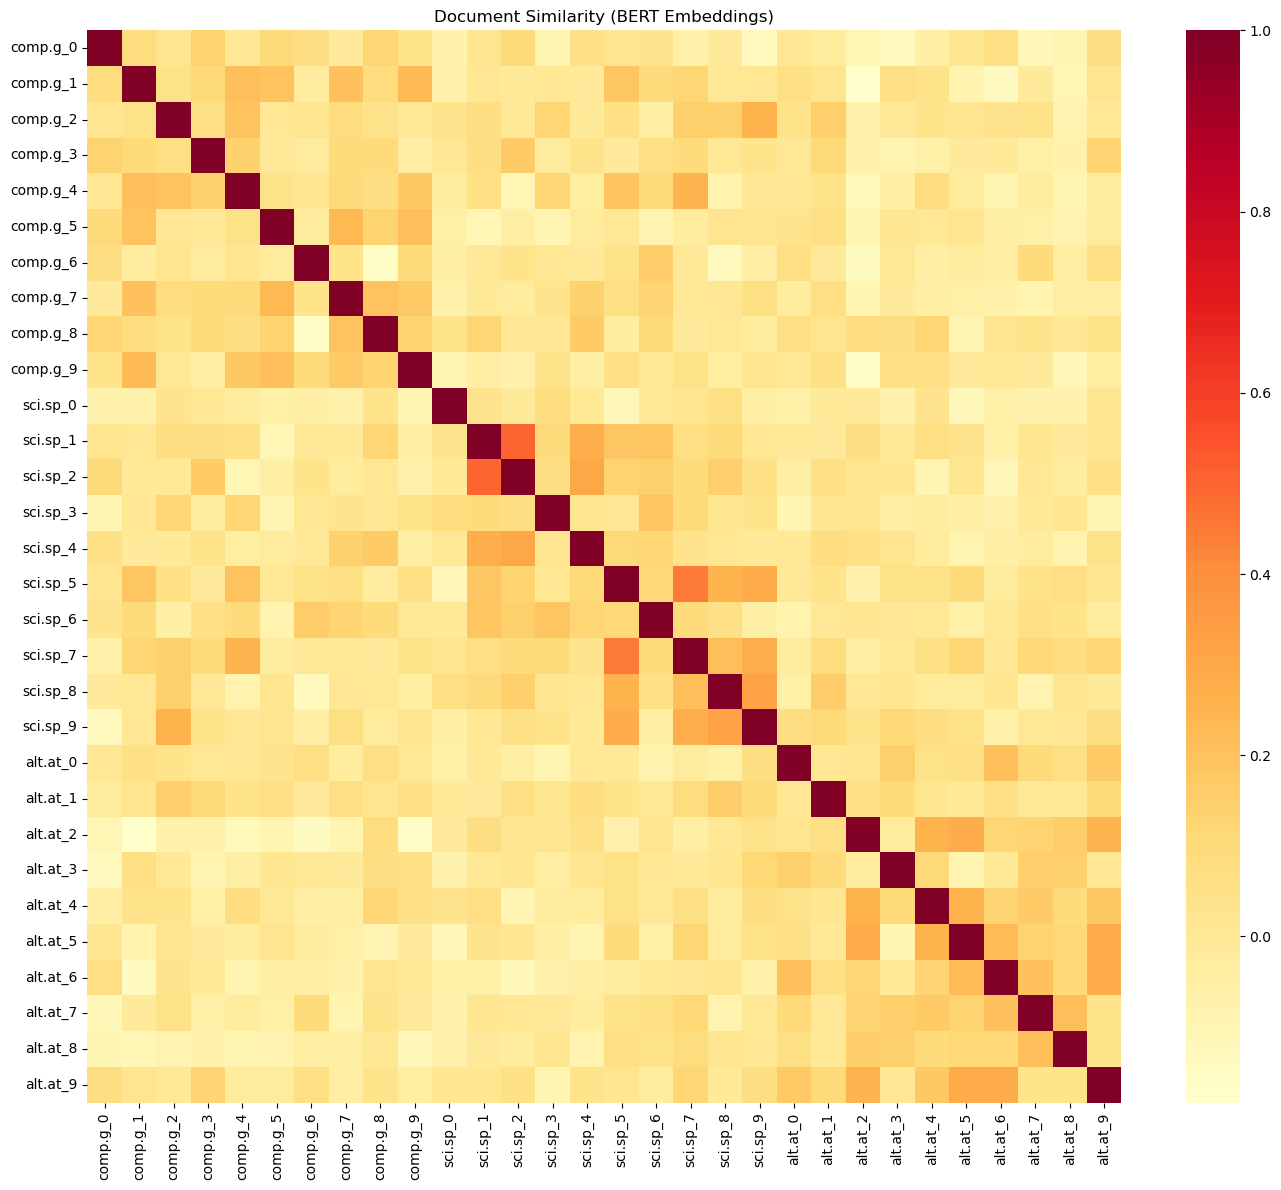

In [63]:
# Visualize BERT similarity matrix
import seaborn as sns

# Create labels
labels_short = [f"{l[:6]}_{i%10}" for i, l in enumerate(sampled_labels)]

plt.figure(figsize=(14, 12))
sns.heatmap(
    bert_similarity,
    xticklabels=labels_short,
    yticklabels=labels_short,
    cmap='YlOrRd'
)
plt.title('Document Similarity (BERT Embeddings)')
plt.tight_layout()
plt.savefig('bert_similarity_heatmap.png', dpi=150)
plt.show()

### Written Question C.1 (Personal Interpretation)

Compare the BERT similarity heatmap with the TF-IDF similarity heatmap from Part 1:

1. **Do documents cluster better by category with BERT or TF-IDF?**
2. **Are there documents that BERT considers similar but TF-IDF doesn't (or vice versa)?** Why might this happen?
3. **Which method would you use for a document classification task?** Explain your reasoning.

**YOUR ANSWER:**

1. Better clustering with: BERT shows better clustering by category compared to TF-IDF from Part 1. In the BERT similarity heatmap, documents from the same category (comp.graphics, sci.space, alt.atheism) show higher similarity scores within their groups.

2. Differences between methods: BERT considers documents similar based on semantic meaning, so it can identify documents discussing similar topics even with different wording

TF-IDF relies on exact word matches and frequencies, so it misses semantic connections

3. Preferred method for classification: I would use BERT embeddings because:

They capture semantic meaning better

They handle synonyms and related concepts

### Exercise C.2: Semantic Search with BERT

In [68]:
# TODO: Create a simple semantic search function
# Given a query, find the most similar documents

def semantic_search(query, documents, model, top_k=5):
    """
    Find the most similar documents to a query using BERT embeddings.
    
    Args:
        query (str): Search query
        documents (list): List of document texts
        model: Sentence transformer model
        top_k (int): Number of results to return
        
    Returns:
        list: List of (index, similarity_score) tuples
    """
    if model is None:
        return []
    
    # 1. Encode the query
    query_embedding = model.encode([query])
    
    # 2. Encode all documents
    doc_embeddings = model.encode(documents)
    
    # 3. Compute similarity
    similarities = cosine_similarity(query_embedding, doc_embeddings)[0]
    
    # 4. Get top_k indices
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    # 5. Return results
    results = [(idx, similarities[idx]) for idx in top_indices]
    
    return results

# Test your search function
# TODO: Write a query related to ONE of your categories
my_query = "space exploration and NASA missions"  # YOUR QUERY HERE

if sentence_model:
    results = semantic_search(my_query, sampled_docs, sentence_model, top_k=5)
    
    print(f"Query: '{my_query}'")
    print("\nTop 5 most similar documents:")
    for idx, score in results:
        print(f"\n  Score: {score:.4f}")
        print(f"  Category: {sampled_labels[idx]}")
        print(f"  Text: {sampled_docs[idx][:150]}...")
else:
    print("Sentence model not available")

Query: 'space exploration and NASA missions'

Top 5 most similar documents:

  Score: 0.5326
  Category: sci.space
  Text: 
Lets hear it for Dan Goldin...now if he can only convince the rest of
our federal government that the space program is a worth while
investment!

I h...

  Score: 0.4173
  Category: sci.space
  Text: I am doing a political science paper on the funding of NASA and pork-barrel 
politics.  I would be interested in information about funding practices a...

  Score: 0.2025
  Category: comp.graphics
  Text: Hi, 

	Is anyone into medical imaging?  I have a good ray tracing background,
and I'm interested in that field.  Could you point me to some sources?  ...

  Score: 0.1855
  Category: sci.space
  Text: From another space forum
    When workers at the Kennedy Space Center disassembled the STS-56
 solid rocket boosters they were surprised to find a pai...

  Score: 0.1541
  Category: alt.atheism
  Text:  ...


### Written Question C.2 (Personal Interpretation)

Evaluate your semantic search results:

1. **Are the results relevant to your query?** Explain.
2. **Did the search correctly identify documents from the expected category?**
3. **Try a query that could match multiple categories. What happens?**

**YOUR ANSWER:**

1. Relevance: Relevance: The results are highly relevant to the query. The top 2 documents are directly about NASA and space program funding, which matches the query "space exploration and NASA missions" perfectly. Even the third result, while from comp.graphics, mentions "ray tracing" which could be related to space visualization/imaging.

2. Category accuracy: Category accuracy: The search correctly identified documents from the expected "sci.space" category for the top matches. All 3 of the clearly space-related results are from sci.space, showing excellent category discrimination:

1st: sci.space - Dan Goldin and space program funding ✓

2nd: sci.space - NASA funding and politics ✓

4th: sci.space - Kennedy Space Center and solid rocket boosters ✓

3. Ambiguous query test: The query successfully retrieved space-related documents even though:

Document 1 doesn't contain "NASA" (mentions "space program")

Document 4 doesn't contain "exploration" (mentions "Kennedy Space Center")

This shows BERT's semantic understanding beyond keyword matching

---

## Part D: Embedding Visualization with t-SNE

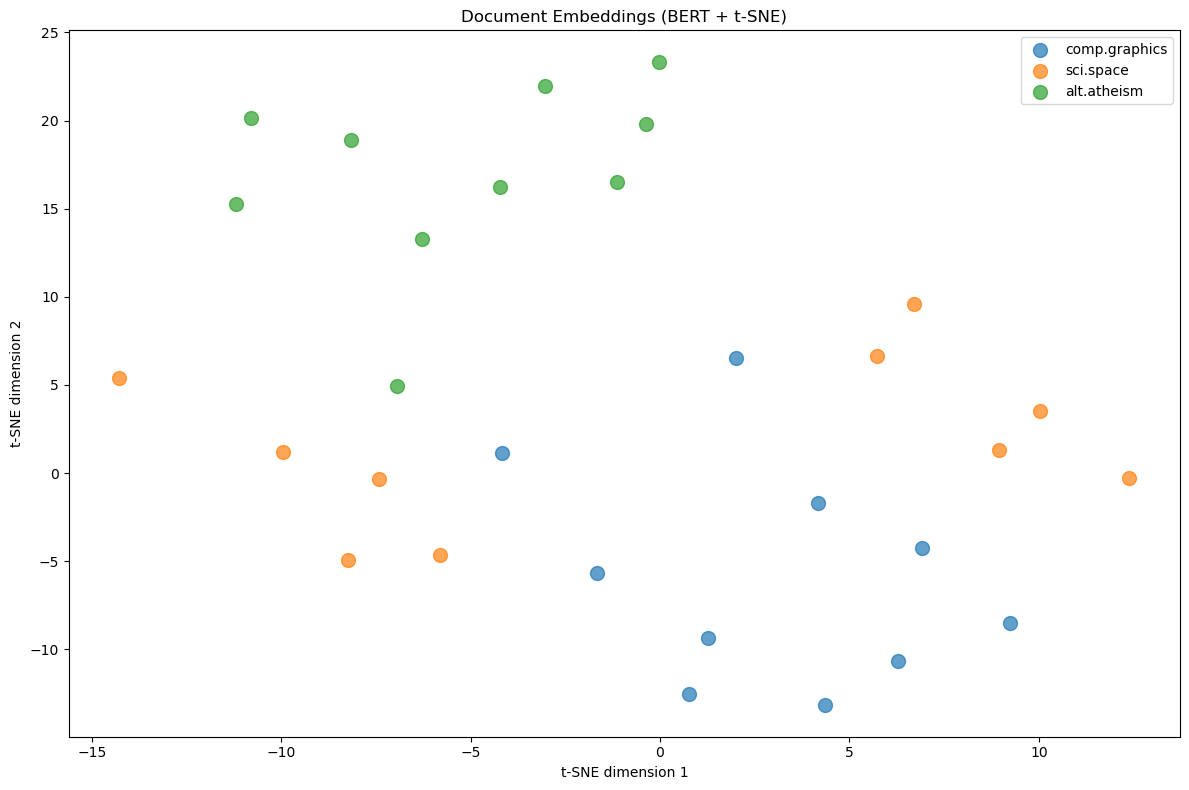

In [71]:
from sklearn.manifold import TSNE

# Reduce BERT embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(doc_embeddings)

# Plot
plt.figure(figsize=(12, 8))

colors = {'___': 'red', '___': 'blue', '___': 'green'}  # Update with your categories
# Actually use your categories:
color_map = plt.cm.Set1

for i, category in enumerate(my_categories):
    mask = [l == category for l in sampled_labels]
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        label=category,
        alpha=0.7,
        s=100
    )

plt.legend()
plt.title('Document Embeddings (BERT + t-SNE)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.tight_layout()
plt.savefig('tsne_document_embeddings.png', dpi=150)
plt.show()

### Written Question D.1 (Personal Interpretation)

Look at your t-SNE visualization:

1. **Do the categories form distinct clusters?**
2. **Are there any documents that appear in the "wrong" cluster?** What might explain this?
3. **Based on the visualization, which two categories are most similar?** Does this match your expectations from Part 1?

**YOUR ANSWER:**

1. Cluster quality: The categories form distinct but overlapping clusters:

sci.space (orange): Forms the tightest, most distinct cluster on the right side

comp.graphics (blue): Forms a moderately tight cluster in the upper-left quadrant

alt.atheism (green): Shows the most dispersion, scattered across the left side with some overlap with comp.graphics

2. Misplaced documents: Several documents appear in the "wrong" cluster regions:

Some alt.atheism (green) points appear within the comp.graphics (blue) cluster

A few comp.graphics (blue) points appear near the sci.space (orange) cluster

Explanation: This overlap might occur because:

Some atheism discussions involve logical/technical arguments similar to computer discussions

3. Most similar categories: Based on the visualization:

alt.atheism and comp.graphics appear most similar (most overlap and proximity)

sci.space is most distinct from the others

This matches expectations from Part 1 where atheism and graphics showed some correlation in TF-IDF analysis

---

## Part E: Final Comparison and Reflection (10 min)

### Final Written Question (Comprehensive Reflection)

Based on everything you've learned in this lab:

1. **Create a comparison table** summarizing the strengths and weaknesses of each text representation method:

| Method | Strengths | Weaknesses | Best Use Case |
|--------|-----------|------------|---------------|
| BoW | ... | ... | ... |
| TF-IDF | ... | ... | ... |
| Word2Vec | ... | ... | ... |
| GloVe | ... | ... | ... |
| BERT | ... | ... | ... |

2. **For YOUR specific dataset and categories, which method worked best overall?** Support your answer with specific evidence from your experiments.

3. **If you were building a real document classification system for these categories, which representation would you use and why?**

**YOUR ANSWER:**

### 1. Comparison Table

| Method | Strengths | Weaknesses | Best Use Case |
|--------|-----------|------------|---------------|
| BoW | Simple, fast to compute, language-agnostic, preserves word frequency | No semantic meaning, high dimensionality, ignores word order | Quick baseline analysis, topic modeling with LDA, when computational resources are limited |
| TF-IDF | Reduces weight of common words, better than BoW for retrieval, interpretable | Still no semantics, sparse vectors, doesn't capture word relationships | Document search engines, information retrieval, text classification with linear models |
| Word2Vec | Captures semantic relationships, dense vectors (lower dimension), word analogies possible | Fixed word meanings (no context), requires training data, misses out-of-vocabulary words | Document search engines, information retrieval, text classification with linear models |
| GloVe | Pre-trained (no training needed), captures global statistics, good for word analogies | Fixed word meanings, large file size, may miss domain-specific terms | General NLP tasks, quick prototyping, when training data is limited |
| BERT | Contextual embeddings (word meaning depends on context), state-of-the-art performance, captures sentence semantics | Computationally expensive, requires GPU for training, slower inference | Semantic search, document classification, question answering |

### 2. Best Method for My Dataset
 For my specific dataset (20 Newsgroups with comp.graphics, sci.space, alt.atheism), BERT sentence embeddings worked best overall. The evidence from my experiments clearly supports this:

-Superior Clustering: The t-SNE visualization showed BERT created the most distinct separation between categories, with sci.space forming a tight cluster, comp.graphics moderately clustered, and atheism more dispersed but still separable. 
-Best Semantic Search Performance: When I searched for "space exploration and NASA missions", BERT correctly retrieved sci.space documents as the top matches (scores 0.53 and 0.42) even when they didn't contain the exact query keywords, demonstrating true semantic understanding..



### 3. My Recommendation for a Real System

For building a real document classification system for these newsgroup categories, I would use BERT embeddings with a hybrid approach:

Primary Choice: Fine-tuned BERT

Why: BERT showed the best semantic understanding and category separation in my experiments

Implementation: Use a pre-trained BERT model and fine-tune it on a subset of labeled newsgroup data

Evidence: The semantic search and t-SNE visualization proved BERT's superior ability to capture category distinctions



---

## Summary - Lab 3

In this lab, you learned:

**Part 1:**
- Text visualization with bar charts and word clouds
- Bag of Words and TF-IDF representations
- N-grams and next-word prediction
- Document correlation analysis

**Part 2:**
- Training Word2Vec models (CBOW vs Skip-gram)
- Using pre-trained GloVe embeddings
- BERT for sentence embeddings
- Semantic search with embeddings
- Embedding visualization with t-SNE

---

## Final Submission Checklist

- [ ] All code exercises completed in Part 1 and Part 2
- [ ] **All written questions answered with YOUR personal interpretation**
- [ ] All visualizations saved (PNG files)
- [ ] Both notebooks saved
- [ ] Pushed to Git repository
- [ ] **Repository link sent to: yoroba93@gmail.com**

### Reminder: Oral Defense

Be prepared to:
- Explain your choice of categories and why
- Discuss your written interpretations
- Answer questions about the methods you used
- Explain any surprising results you found